In [116]:
import pandas as pd
import sklearn
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
%matplotlib inline

In [6]:
raw_df = pd.read_excel("http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx")  # use your data instead of the url
origin = raw_df.copy()
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [7]:
# Prepare data to have a hypothetical wehales class

raw_df = raw_df.dropna()
raw_df.drop(columns=['StockCode', 'Description'], inplace=True)
raw_df['Quantity'] = raw_df['Quantity'].apply(lambda x: int(x))
raw_df['CustomerID'] = raw_df['CustomerID'].apply(lambda x: int(x))
raw_df['UnitPrice'] = raw_df['UnitPrice'].apply(lambda x: float(x))
raw_df = raw_df.drop(raw_df[raw_df.Quantity <= 0].index)
raw_df['Transaction'] = raw_df["UnitPrice"] * raw_df["Quantity"]
lastDate = raw_df['InvoiceDate'].iloc[-1]
raw_df = raw_df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (lastDate - x.max()).days, 
                                           'InvoiceNo': lambda x: len(x), 
                                           'Transaction': lambda x: x.sum()})
raw_df['InvoiceDate'] = raw_df['InvoiceDate'].astype(int)
raw_df.rename(columns={'InvoiceDate': 'recency', 
                         'InvoiceNo': 'frequency', 
                         'Transaction': 'monetary'}, inplace=True)

from sklearn.preprocessing import StandardScaler

def scale(df):
    ss = StandardScaler()
    return pd.DataFrame(ss.fit_transform(df[['recency', 'frequency', 'monetary']]), columns=['res', 'freq', 'mon'])

    
raw_df = scale(raw_df)

raw_df.head()

/home/alisa/projects/ml-showcase/env/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/alisa/projects/ml-showcase/env/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,res,freq,mon
0,2.334858,-0.396512,8.359634
1,-0.905199,0.394688,0.251046
2,-0.175186,-0.265374,-0.028546
3,-0.735196,-0.081781,-0.032963
4,2.174855,-0.326572,-0.191315


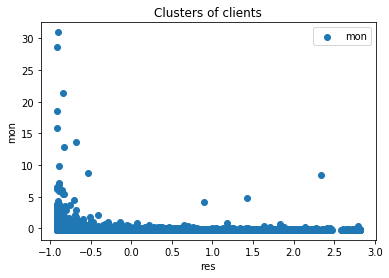

In [12]:
colors = ['blue', 'yellow', 'green', 'red', 'orange', 'purple', 'pink']

def prepare_clustered_data(column1, column2):
    plt.scatter(raw_df[column1], raw_df[column2])
    plt.title('Clusters of clients')
    plt.xlabel('{}'.format(column1))
    plt.ylabel('{}'.format(column2))
    plt.legend()
    
prepare_clustered_data('res', 'mon')

In [53]:
# Let's define whales as everything above monatry value 5:
X = raw_df.copy()
X['whale'] = X['mon'].apply(lambda x: 1 if x > 1 else 0)
X.head()

,res,freq,mon,whale
0,2.334858,-0.396512,8.359634,1
1,-0.905199,0.394688,0.251046,0
2,-0.175186,-0.265374,-0.028546,0
3,-0.735196,-0.081781,-0.032963,0
4,2.174855,-0.326572,-0.191315,0


In [54]:
X.shape

(4339, 4)

90
0.020742106476146577
4249
0.9792578935238534


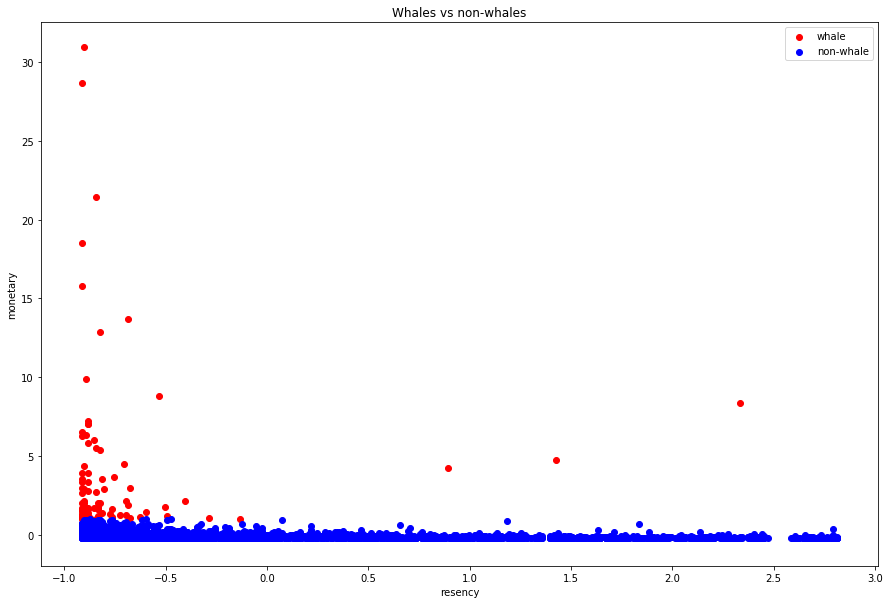

In [60]:
import random.permuation as permut

whales = X[X['whale'] == 1].copy()
normal = X[X['whale'] == 0].copy()
print(whales.shape[0])
print(whales.shape[0] / X.shape[0])
print(normal.shape[0])
print(normal.shape[0] / X.shape[0])

fig = plt.figure(figsize=(15,10))
plt.scatter(whales["res"], whales["mon"], c='red', label='whale')
plt.scatter(normal["res"], normal["mon"], c='blue', label='non-whale')
plt.title('Whales vs non-whales')
plt.xlabel('{}'.format("resency"))
plt.ylabel('{}'.format("monetary"))
plt.legend()


In [62]:
# So we have 2% of whales in the whole dataset
# 1. let's get try to run a classification problem with random forest and bootstrapping of non-whale class
# 2. manual features and rule based approach
# 3. synthetic data - require proper knowledfe of the data
# 4. autoencoders - would not go there, it's a simple NN, but quite fancy
whales = whales.reindex(np.random.permutation(whales.index))
normal = normal.reindex(np.random.permutation(normal.index))

,res,freq,mon,whale
481,-0.885199,0.932354,1.016568,1
3066,-0.905199,0.399059,1.221030,1
100,-0.905199,1.609901,1.977282,1
3676,-0.835198,0.075585,2.027527,1
1690,-0.905199,8.691357,30.949777,1


In [102]:
# Prepare train and test sets as always
X_train = normal[:int(normal.shape[0] * 0.7)].copy()
w_train = whales[:int(whales.shape[0] * 0.7)].copy()
X_train = X_train.append(w_train, ignore_index=True)
X_train = X_train.reindex(np.random.permutation(X_train.index))

X_test = normal[int(normal.shape[0] * 0.7):].copy()
w_test =whales[int(whales.shape[0] * 0.7):].copy()
X_test = X_test.append(w_test, ignore_index=True)
X_test = X_test.reindex(np.random.permutation(X_test.index))

(2974, 4)
(62, 4)
(3036, 4)
(1275, 4)
(28, 4)
(1303, 4)


In [130]:
# Check penalty in RFC
X_train_penalty_target = X_train['whale'].copy()
X_train_penalty_features = X_train.drop(columns=['whale', 'mon'])
X_test_penalty_target = X_test['whale'].copy()
X_test_penalty_features = X_test.drop(columns=['whale', 'mon'])


from sklearn.ensemble import RandomForestClassifier
built_in_penalty = RandomForestClassifier(n_estimators=100,class_weight='balanced_subsample', warm_start=True)
built_in_penalty.fit(X_train_penalty_features, X_train_penalty_target)

/home/alisa/projects/ml-showcase/env/lib/python3.7/site-packages/sklearn/ensemble/forest.py:502: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or "balanced_subsample" are '


RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=True)

In [131]:
def misshit(actual, prediction):
    """ Calculate misshits in general and for each class 
        FP = was not labeled as whale, but it is not a whale
        FN = was labeled as non-whale, but it is
        TP = is predicted as a whale, is a whale
        TN = is non-whale on both sides
    """
    positive = 1  # label whale
    negative = 0  # label non-whale
    assert(len(actual) == len(prediction))
    total_misshits = 0
    FP = 0
    FN = 0
    TP = 0 
    TN = 0
    for i in range(len(prediction)):
        if prediction[i] != actual[i]:
            total_misshits += 1
            if prediction[i] == 0:
                FN += 1
            else:
                FP += 1
        else:
            if prediction[i] == 0:
                TN += 1
            else:
                TP +=1
    return total_misshits, FP, FN, TP, TN
        


In [132]:
built_in_penalty_predict = built_in_penalty.predict(X_test_penalty_features)
misshit(X_test_penalty_target.tolist(), predicted.tolist())

(0, 0, 0, 28, 1275)

No handles with labels found to put in legend.


1.0


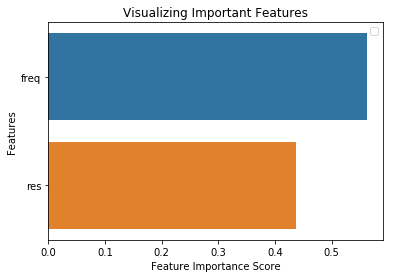

In [133]:
# The rule was in this case way too simple apparently:
from sklearn import metrics

print(metrics.accuracy_score(X_test_penalty_target.tolist(), predicted.tolist()))

feature_imp = pd.Series(built_in_penalty.feature_importances_,index=['res', 'freq']).sort_values(ascending=False)
feature_imp
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

RandomForest is quite powerful on sm,aller datasets in comparison to NNs
1. class_weight='balanced_subsample' - will give more weight to a rare class
2. warm_start=True - reuse previous weights
2. max_depth = how many rules does a tree have

In [160]:
### 1.2 approach for other models (alternative to warm_start)
# every learning run take whales and same amount of arndomized non-whales - this is the new train set for a run 
# putting back non-whales or not - both vaibale approaches, since randomization is taking place.
# every next learning start with already learnt weights
X_train_boostrap = normal[:int(normal.shape[0] * 0.7)].copy()
w_train_boostrap = whales[:int(whales.shape[0] * 0.7)].copy()

X_test_boostrap = normal[int(normal.shape[0] * 0.7):].copy()
w_test_boostrap = whales[int(whales.shape[0] * 0.7):].copy()
X_test_boostrap = X_test_boostrap.append(w_test_boostrap, ignore_index=True)
X_test_boostrap = shuffle(X_test_boostrap)
X_test_boostrap_target = X_test_boostrap['whale'].copy()
X_test_boostrap_feature = X_test_boostrap.drop(columns=['whale', 'mon'])

def shuffle(df):
    """ Random order of rows """
    return df.reindex(np.random.permutation(df.index))

# smth like this:
ATTEPMPTS = 21
bootstrap_model = RandomForestClassifier(n_estimators=100, warm_start=True)

for i in range(ATTEPMPTS):
    # create new smaller  batches of data for the algorithm: get random rows
    features = X_train_boostrap.sample(n=w_train_boostrap.shape[0], random_state=1)
    X_small = features.append(w_train_boostrap, ignore_index=True)
    X_small = shuffle(X_small)
    X_small_target = X_small['whale'].copy()
    X_small_feature = X_small.drop(columns=['whale', 'mon'])
    X_small_feature.shape
    X_train_boostrap.drop(features.index.tolist(), inplace=True)
    bootstrap_model.n_estimators += 1
    bootstrap_model.fit(X_small_feature, X_small_target)

bootstrap_result = bootstrap_model.predict(X_test_boostrap_feature)
misshit(X_test_boostrap_target.tolist(), bootstrap_result.tolist())

# This method does not work that well in trees, since it sees whales way too often, 
# but it might work in NN if you use normalization or any other penalty for overfitting


(289, 282, 7, 21, 993)

 2. Manual features: map all features against target to see distributions and behaviour. 
 Best case scenario - target class is an outlier in certain feature combination
 
 This might get ugly due to potential amount of dimensions - interpretability dies off very quickly 

3. Synthetic data
- Very similar to manual tree creation,
- create more data by altering existing rows to be still a whale withing given boundary
- downside: you really need to have a very good understanding of all feeature connections


```new_row = old_row['rec'] - 1, old_row['mon'] + 2, old_row['freq'] + 0.2 - as an example```